In [1]:
%cd ../..

/remote/rds/users/s2086085/causica


In [90]:
from castle.datasets import IIDSimulation
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from functorch import vmap, jacrev, grad
from matplotlib.colors import ListedColormap
import pandas as pd
from pathlib import Path
# internal
from diffscm.diffanm import DiffANM

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [91]:
figures_path = Path("diffscm/experiments/figures")

# Get data

2022-08-30 11:44:00,631 - /remote/rds/users/s2086085/miniconda3/envs/functorch_cud11/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:>

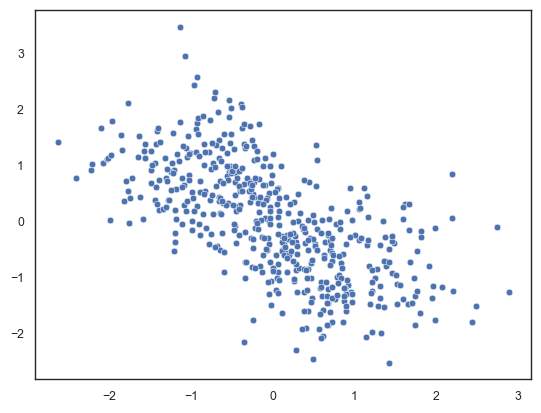

In [38]:
dag = np.zeros((2,2))
dag[0,1] = 1
dataset = IIDSimulation(W=dag, n=1000, method='nonlinear', sem_type="mlp", noise_scale = 2.0)
X = dataset.X
X = (X - X.mean(0, keepdims = True)) / X.std(0, keepdims = True)    
n_samples_vis = 500
sns.scatterplot(X[:n_samples_vis,0], X[:n_samples_vis,1])   

In [39]:
# An n by n grid for the heatmap
n = 100
bb_min = -3
bb_max = 3
d1_min =  bb_min
d1_max =  bb_max
d2_min =  bb_min
d2_max =  bb_max
d1, d2 = torch.meshgrid([
    torch.linspace(d1_min, d1_max, n),
    torch.linspace(d2_min, d2_max, n)])
heatmap_plane = torch.stack((d1.flatten(), d2.flatten()), dim=1)
heatmap_plane.shape

torch.Size([10000, 2])

# Train

In [87]:
diffanm = DiffANM(n_nodes = 2, batch_size = 128)

data_loader = torch.utils.data.DataLoader(X, diffanm.batch_size, shuffle = True)
heatmap_plane_torch = torch.FloatTensor(heatmap_plane).to(device)
t_functorch = (torch.ones(1)*50).long().to(diffanm.device)
jacobians_score = []
pbar = tqdm(range(200), desc = "Training Epoch")
for epoch in pbar:
    diffanm.model.train()
    for steps, x_start in enumerate(data_loader):
        # apply noising and masking
        x_start = x_start.float().to(diffanm.device)
        t, weights = diffanm.schedule_sampler.sample(x_start.shape[0], diffanm.device)
        noise = torch.randn_like(x_start).to(diffanm.device)
        x_t = diffanm.gaussian_diffusion.q_sample(x_start, t, noise=noise)
        # get loss function
        model_output = diffanm.model(x_t, diffanm.gaussian_diffusion._scale_timesteps(t))
        diffusion_losses = (noise - model_output) ** 2
        diffusion_losses_dropped = diffusion_losses
        diffusion_loss = (diffusion_losses_dropped.mean(dim=list(range(1, len(diffusion_losses_dropped.shape)))) * weights).mean()
        
        diffanm.opt.zero_grad()
        diffusion_loss.backward()
        diffanm.opt.step()
        
        pbar.set_postfix({'Val Loss': diffusion_loss.item()})
    if epoch % 10 == 0:
        with torch.no_grad():
            diffanm.model.eval()
            model_fn_functorch = lambda x: diffanm.model(x, diffanm.gaussian_diffusion._scale_timesteps(t_functorch))
            jacobian_score = vmap(jacrev(model_fn_functorch))(heatmap_plane_torch.unsqueeze(1)).squeeze()
            jacobians_score.append(jacobian_score.detach().cpu().numpy())
            

Training Epoch: 100%|██████████| 200/200 [00:09<00:00, 20.26it/s, Val Loss=0.809]


# Inference

In [88]:
diffanm.model.eval()
X_torch = torch.FloatTensor(heatmap_plane).to(device)
t_functorch = (torch.ones(1)*50).long().to(diffanm.device)
model_fn_functorch = lambda x: diffanm.model(x, diffanm.gaussian_diffusion._scale_timesteps(t_functorch))
# active_nodes selects for which inputs the jacobian is computed 
score = vmap(model_fn_functorch)(X_torch.unsqueeze(1))
jacobian_score = vmap(jacrev(model_fn_functorch))(X_torch.unsqueeze(1)).squeeze()
jacobian_var_diag = jacobian_score.detach().cpu().numpy().var(0).diagonal()
jacobian_var_diag

array([0.12471642, 0.06938183], dtype=float32)

# Visualization

0.1247166
0.069381766


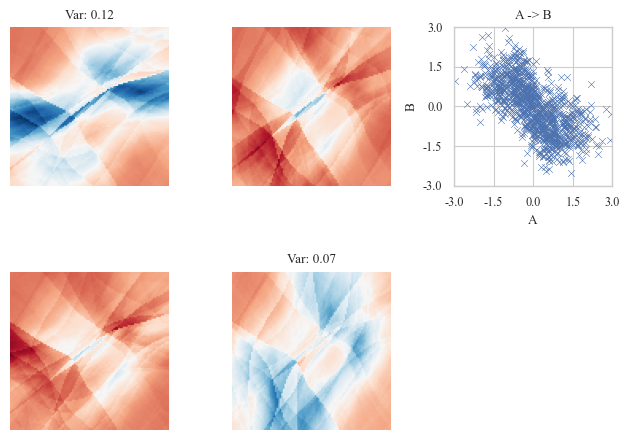

In [94]:
sns.set(context = 'paper',style='whitegrid', font_scale=1,
            rc={'font.family':'serif', #'figure.figsize':(2.75,2)
            'font.size':'10','font.serif':['Times New Roman'],"lines.linewidth":'1','legend.fontsize':'8'})
X_df = pd.DataFrame(data=X, index=range(X.shape[0]), columns = ["A","B"])

jacobian_score_np = jacobian_score.detach().cpu().numpy()
hessian_heatmap_00 = jacobian_score_np[:,0,0].reshape(n, n)
hessian_heatmap_01 = jacobian_score_np[:,0,1].reshape(n, n)
hessian_heatmap_10 = jacobian_score_np[:,1,0].reshape(n, n)
hessian_heatmap_11 = jacobian_score_np[:,1,1].reshape(n, n)

vmin = jacobian_score_np.min()
vmax = jacobian_score_np.max()

plt.subplot(231)
plt.imshow(hessian_heatmap_00, vmin=vmin, vmax=vmax, cmap = plt.cm.RdBu )
plt.title(f"Var: {hessian_heatmap_00.var():.2f}")
plt.axis('off')
plt.subplot(232)
plt.imshow(hessian_heatmap_01, vmin=vmin, vmax=vmax, cmap = plt.cm.RdBu )
plt.axis('off')
plt.subplot(235)
plt.imshow(hessian_heatmap_11, vmin=vmin, vmax=vmax, cmap = plt.cm.RdBu )
plt.title(f"Var: {hessian_heatmap_11.var():.2f}")
plt.axis('off')
plt.subplot(234)
plt.imshow(hessian_heatmap_10, vmin=vmin, vmax=vmax, cmap = plt.cm.RdBu )
plt.axis('off')
plt.subplot(233, adjustable='box', aspect=1)
scat = sns.scatterplot(data = X_df, x ="A", y = "B", marker = 'x')
tick_range = list(np.arange(-3,3+1.5,1.5))
scat.set_xticks(tick_range, labels=tick_range)
scat.set_yticks(tick_range, labels=tick_range)
#scat[0].set(xlim=(-3,3),ylim=(-3,3))
#sns.despine(bottom=True, left=True)
plt.xlim([-3, 3]),plt.ylim([-3, 3])
plt.title("A -> B")

plt.tight_layout()
print(hessian_heatmap_00.var())
print(hessian_heatmap_11.var())
plt.savefig(figures_path / "two_variables_hessian.pdf", bbox_inches = 'tight')

In [92]:
a = 0.123456
print(f"{a:.2f}")

0.12


In [63]:
list(np.arange(-3,3+1.5,1.5))

[-3.0, -1.5, 0.0, 1.5, 3.0]

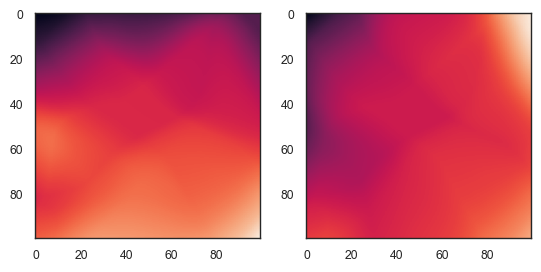

In [10]:
score_heatmap_0 = score.detach().cpu().numpy().squeeze()[:,0].reshape(n, n)
score_heatmap_1 = score.detach().cpu().numpy().squeeze()[:,1].reshape(n, n)
plt.subplot(121)
plt.imshow(score_heatmap_0)
plt.subplot(122)
plt.imshow(score_heatmap_1)